In [315]:
import os
import numpy as np
import tifffile
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

from DLC_for_WBFM.utils.feature_detection.feature_pipeline import *
from DLC_for_WBFM.utils.feature_detection.utils_tracklets import *
from DLC_for_WBFM.utils.feature_detection.utils_detection import *
from DLC_for_WBFM.utils.feature_detection.visualization_tracks import *
from DLC_for_WBFM.utils.feature_detection.utils_candidate_matches import *
from DLC_for_WBFM.utils.video_and_data_conversion.import_video_as_array import *
import networkx as nx
from DLC_for_WBFM.utils.feature_detection.utils_reference_frames import *
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Get the 3d bigtiff folder
bigtiff_folder = r'D:\More-stabilized-wbfm'

btf_fname_red = r'test2020-10-22_16-15-20_test4-channel-0-pco_camera1\test2020-10-22_16-15-20_test4-channel-0-pco_camera1bigtiff.btf'
btf_fname_red = os.path.join(bigtiff_folder, btf_fname_red)


In [323]:
# Same opt for both
opt = {'start_frame':50,
       'num_frames':500,
       'verbose':0,
       'num_subsequent_matches':19,
       'save_candidate_matches':True,
       'add_affine_to_candidates':True,
       'add_gp_to_candidates':False}

p = PreprocessingSettings()
p.do_filtering=False
p.do_rigid_alignment=True
p.do_mini_max_projection=True
out = track_neurons_full_video_window(btf_fname_red, **opt, preprocessing_settings=p)
all_matches, all_conf, all_frames, candidates = out

 84%|███████████████████████████████████████████████████████████████▏           | 421/500 [11:09:39<2:08:00, 97.22s/it]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 84%|███████████████████████████████████████████████████████████████▎           | 422/500 [11:11:12<2:04:53, 96.07s/it]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 85%|███████████████████████████████████████████████████████████████▍           | 423/500 [11:12:50<2:04:07, 96.72s/it]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 91%|████████████████████████████████████████████████████████████████████▎      | 455/500 [12:04:41<1:13:52, 98.49s/it]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


 92%|█████████████████████████████████████████████████████████████████████      | 460/500 [12:12:41<1:04:11, 96.29s/it]

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


100%|█████████████████████████████████████████████████████████████████████████████| 500/500 [13:20:15<00:00, 96.03s/it]


### Collected postprocessing functions

In [324]:
all_communities = calc_neurons_using_k_cliques(all_matches,
                                 k_values = [13,11,9,7],
                                 list_min_sizes = [450, 400],
                                 max_size = 500)

75936 nodes remaining
75460 nodes remaining
71600 nodes remaining
67803 nodes remaining
67391 nodes remaining
66084 nodes remaining
60001 nodes remaining
58308 nodes remaining


In [325]:
clique_matches = community_to_matches(all_communities)

In [326]:
# Force a restart at 0; the video later will have to start at the same point
list_frames = list(all_frames.values())
clust_df = build_tracklets_from_classes(list_frames, dict(clique_matches), verbose=0)

In [327]:
suffix = 'sequential19'

fname = f'clust_df_dat_{suffix}.pickle'
with open(fname, 'wb') as f:
    pickle.dump(clust_df,f)
fname = f'match_dat_{suffix}.pickle'
with open(fname, 'wb') as f:
    pickle.dump(clique_matches, f)
fname = f'frame_dat_{suffix}.pickle'
[frame.prep_for_pickle() for frame in list_frames]
with open(fname, 'wb') as f:
    pickle.dump(list_frames, f)

## Tests: Postprocess 

In [231]:
bp_match_dict = {}
min_edge_weight = 0.5
for key in all_matches:
    these_candidates = [c for c in candidates[key] if c[-1]>min_edge_weight]
    bp_matches = calc_bipartite_matches(these_candidates)
    bp_match_dict[key] = bp_matches
DG_bp = build_digraph_from_matches(bp_match_dict, verbose=0)

Largest connected component size:  4957
Sizes and number of components:
[2, 13]
[3, 6]
[4, 7]
[6, 2]
[8, 2]
[9, 2]
[11, 3]
[36, 3]
[37, 3]
[4957, 1]


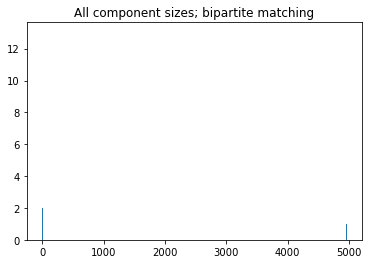

In [5]:
%matplotlib inline
thresh = 0.0

G = get_subgraph_with_strong_weights(DG_bp, thresh)
big_G, all_sz, all_neurons = calc_connected_components(G, False)
plt.hist([z for z in all_sz if z > 1], bins=list(range(1,max(all_sz)+2)));
plt.title('All component sizes; bipartite matching')

[vals, counts] = np.unique(all_sz, return_counts=True)
print("Sizes and number of components:")
for v, c in zip(vals, counts):
      print([v, c])

In [161]:
# nx.draw(DG_bp)

In [200]:
tmp = nx.DiGraph()
# tmp.add_weighted_edges_from(candidates[(0,1)])
key = (0,1)
for e in candidates[key]:
    if tmp.has_edge(e[0],e[1]):
        tmp[e[0]][e[1]]['weight'] += e[2]
    else:
        tmp.add_weighted_edges_from([e])

### Just do a smaller network (fewer neurons)


In [130]:
# test_keys = list(all_matches.keys())[:6]
# test_keys = list(all_matches.keys())[:10]
test_keys = [(0,1),(0,2),(1,2)]
print("Only including:")
print(test_keys)

bp_match_dict_small = {}
for key in test_keys:
    bp_matches = calc_bipartite_matches(candidates[key])
    bp_match_dict_small[key] = bp_matches
DG_bp_small = build_digraph_from_matches(bp_match_dict_small, verbose=0)

Only including:
[(0, 1), (0, 2), (1, 2)]


Largest connected component size:  19
Sizes and number of components:
[2, 5]
[3, 104]
[4, 3]
[5, 5]
[6, 1]
[7, 3]
[8, 2]
[11, 1]
[14, 1]
[17, 1]
[19, 1]


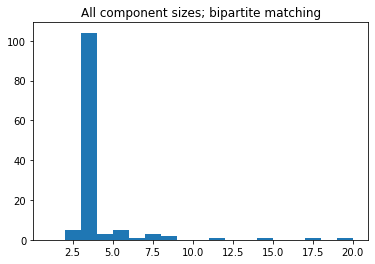

In [131]:
%matplotlib inline
thresh = 0.0

G = get_subgraph_with_strong_weights(DG_bp_small, thresh)
big_G, all_sz, all_neurons = calc_connected_components(G, False)
plt.hist([z for z in all_sz if z > 1], bins=list(range(1,max(all_sz)+2)));
plt.title('All component sizes; bipartite matching')

[vals, counts] = np.unique(all_sz, return_counts=True)
print("Sizes and number of components:")
for v, c in zip(vals, counts):
      print([v, c])

In [193]:
k = (0,2)
to_match = 2
f = lambda i : print(f"{to_match} matched with {i}")

[i for i,m in enumerate(bp_match_dict_small[k]) if m[0]==to_match]

[]

## Draw matches with three planes

In [337]:
from DLC_for_WBFM.utils.feature_detection.visualization_tracks import plot_three_point_clouds
plot_three_point_clouds(all_frames, bp_match_dict, ind=90)

[PointCloud with 143 points.,
 PointCloud with 141 points.,
 LineSet with 137 lines.,
 PointCloud with 143 points.,
 PointCloud with 136 points.,
 LineSet with 132 lines.,
 PointCloud with 141 points.,
 PointCloud with 136 points.,
 LineSet with 132 lines.]

In [328]:
lines01 = plot_matched_point_clouds(all_frames,
                                            bp_match_dict,
                                            (0,1), 
                                            color=[1,0,0],
                                            actually_draw=False)
lines02 = plot_matched_point_clouds(all_frames,
                                            bp_match_dict,
                                            (0,2), 
                                            color=[0,1,0],
                                            actually_draw=False)
lines12 = plot_matched_point_clouds(all_frames,
                                            bp_match_dict,
                                            (1,2), 
                                            color=[0,0,1],
                                            actually_draw=False)

KeyError: 0

In [ ]:
to_draw = list(lines01)
to_draw.extend(lines02)
to_draw.extend(lines12)
o3d.visualization.draw_geometries(to_draw)

In [49]:
all_frames[7].frame_ind

4

# Attempts to cluster (failed so far)

## k-cliques

Communities are formed by "rolling" a template clique of k connections around the graph; boundaries exists when a clique of size k can't be "fit" through the connections

In [182]:
from networkx.algorithms.community import k_clique_communities
G = DG_bp.to_undirected().copy()

communities = list(k_clique_communities(G, k=6))

In [183]:
# communities[0]

Text(0.5, 1.0, 'All sizes')

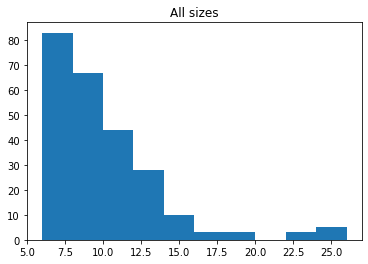

In [184]:
all_len = [len(c) for c in communities]
%matplotlib inline
plt.hist(all_len)
plt.title("All sizes")

### K-cliques at scale

In [233]:
# Do a list of descending clique sizes
k_values = [5,4,3]
list_min_sizes = [450, 400, 350, 300, 250]
max_size = 500
G = DG_bp.to_undirected().copy()

all_communities = []

# Multiple passes: take largest communities first
for min_size in list_min_sizes:
    for k in k_values:
        communities = list(k_clique_communities(G, k=k))
        nodes_to_remove = []
        for c in communities:
            if len(c) > min_size and len(c) < max_size:
                nodes_to_remove.extend(c)
                all_communities.append(c)
        G.remove_nodes_from(nodes_to_remove)
        print(f"{len(G.nodes)} nodes remaining")
    max_size = min_size
    
# Second pass: allow smaller communities
# min_size, max_size = 15, min_size 
# for k in k_values:
#     communities = list(k_clique_communities(G, k=k))
#     nodes_to_remove = []
#     for c in communities:
#         if len(c) > min_size and len(c) < max_size:
#             nodes_to_remove.extend(c)
#             all_communities.append(c)
#     G.remove_nodes_from(nodes_to_remove)
#     print(f"{len(G.nodes)} nodes remaining")

73063 nodes remaining
73063 nodes remaining
72610 nodes remaining
71337 nodes remaining
69199 nodes remaining
65380 nodes remaining
65380 nodes remaining
64598 nodes remaining
63068 nodes remaining
63068 nodes remaining
63068 nodes remaining
61484 nodes remaining
60372 nodes remaining
59818 nodes remaining
57039 nodes remaining


Text(0.5, 1.0, 'Sizes of 46 communities')

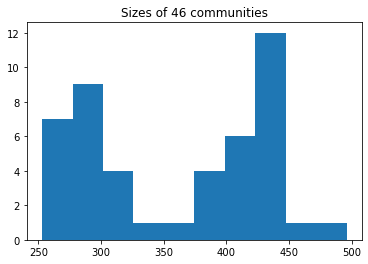

In [234]:
all_len = [len(c) for c in all_communities]
%matplotlib inline
plt.hist(all_len)
plt.title(f"Sizes of {len(all_communities)} communities")

In [307]:
community_dict = {}
for i, c in enumerate(all_communities):
    name = f"neuron_{i}"
    for neuron in c:
        community_dict[neuron]=name 
# G = DG_bp.to_undirected().copy()
clique_matches = convert_labels_to_matches(community_dict, offset=50, max_frames=500)

In [ ]:
f0 = 50
k = (f0, f0+1)
opt = {'all_frames':all_frames,'which_pair':k,'actually_draw':False}

cluster_lines01 = plot_matched_point_clouds(neuron_matches=bp_match_dict,
                                            **opt,
                                            color=[0,0,1])
original_lines01 = plot_matched_point_clouds(neuron_matches=clique_matches,
                                             **opt,
                                            color=[0,1,0])
# lines12 = plot_matched_point_clouds(all_frames,
#                                             bp_match_dict,
#                                             (1,2), 
#                                             color=[0,0,1],
#                                             actually_draw=False)

In [ ]:
to_draw = [line.translate([0.5,0.5,0]) for line in cluster_lines01]
to_draw.extend(original_lines01)
# to_draw.extend(lines12)
o3d.visualization.draw_geometries(to_draw)

In [251]:
import pickle

In [308]:
# Force a restart at 0; the video later will have to start at the same point
list_frames = list(all_frames.values())
clust_df = build_tracklets_from_classes(list_frames, dict(clique_matches), verbose=0)

In [309]:
fname = 'clust_df_dat_sequential7.pickle'
with open(fname, 'wb') as f:
    pickle.dump(clust_df,f)
fname = 'match_dat_sequential7.pickle'
with open(fname, 'wb') as f:
    pickle.dump(clique_matches, f)

In [310]:
fname = 'frame_dat_sequential7.pickle'
[frame.prep_for_pickle() for frame in list_frames]
with open(fname, 'wb') as f:
    pickle.dump(list_frames, f)

## Node classification

Relies on manually determined starting nodes and labels

In [101]:
G = DG_bp.to_undirected().copy()
# start_frame = opt['start_frame']

In [102]:
# Which frame should start?
base_frame = 70
lines =  plot_matched_point_clouds(all_frames,
                                            bp_match_dict,
                                            (base_frame,base_frame+1))

In [103]:
# Add a unique label to each neuron on the first frame
neuron_ind = 1
for i in G:
    frame_ind, _ = unpack_node_name(i)
    if frame_ind == base_frame:
        G.nodes[i]['label'] = f"neuron_{neuron_ind}"
        neuron_ind += 1


In [114]:
from networkx.algorithms import node_classification

labels = node_classification.harmonic_function(G, max_iter=1000)

<IPython.core.display.Javascript object>


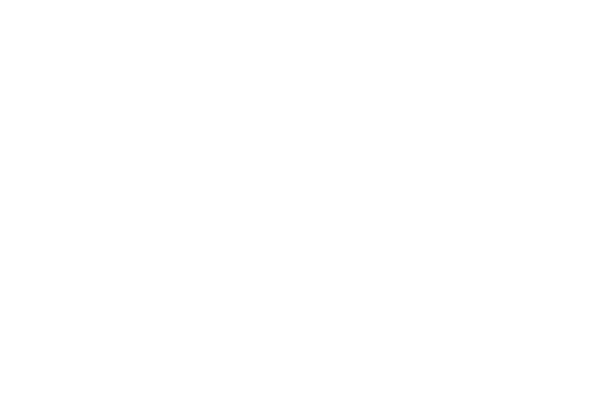

Text(0.5, 1.0, '147 neurons counted')

In [115]:

vals, counts = np.unique(labels, return_counts=True)
plt.hist(counts)
plt.title(f"{neuron_ind-1} neurons counted")

In [116]:
# Turn these matches into a dictionary for visualization
from collections import defaultdict
harmonic_dict = defaultdict(list)
unique_labels = np.unique(labels)
# start_frame = opt['start_frame']
node_list = list(G.nodes)

for name in unique_labels:
    # Get nodes of this class
    these_ind = []
    for i, lab in enumerate(labels):
        if lab!=name:
            continue
        node_ind = node_list[i]
        frame_ind, local_ind = unpack_node_name(node_ind)
        these_ind.append((frame_ind, local_ind))
    # Build matches that know the starting frame
    for i_f0, i_l0 in these_ind:
        for i_f1, i_l1 in these_ind:
            if i_l0 == i_l1 and i_f0==i_f1:
                continue
            k = (i_f0, i_f1)
            harmonic_dict[k].append([i_l0, i_l1])

In [117]:
f0 = 71
k = (f0, f0+1)
opt = {'all_frames':all_frames,'which_pair':k,'actually_draw':False}

cluster_lines01 = plot_matched_point_clouds(neuron_matches=bp_match_dict,
                                            **opt,
                                            color=[0,0,1])
original_lines01 = plot_matched_point_clouds(neuron_matches=harmonic_dict,
                                             **opt,
                                            color=[0,1,0])
# lines12 = plot_matched_point_clouds(all_frames,
#                                             bp_match_dict,
#                                             (1,2), 
#                                             color=[0,0,1],
#                                             actually_draw=False)

In [118]:
to_draw = [line.translate([0.5,0.5,0]) for line in cluster_lines01]
to_draw.extend(original_lines01)
# to_draw.extend(lines12)
o3d.visualization.draw_geometries(to_draw)

In [122]:
# Draw subgraph of a single label
this_label = 'neuron_1'
# start_frame = opt['start_frame']
node_list = list(G.nodes)

# Get nodes of this class
these_nodes = []
for i, lab in enumerate(labels):
    if lab!=this_label:
        continue
#     print(lab)
    these_nodes.append(node_list[i])
#     frame_ind, local_ind = unpack_node_name(node_ind)
#     these_ind.append((frame_ind, local_ind))

G_sub = G.subgraph(these_nodes)

<IPython.core.display.Javascript object>


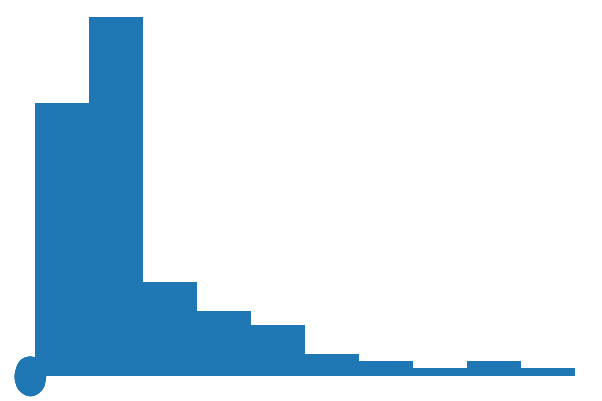

In [123]:
%matplotlib notebook
nx.draw(G_sub, label=True)

## Try to cluster these: k_edge_components

Generates nodes in subgraphs that must be k-edge-connected

In [132]:
c = nx.algorithms.connectivity.edge_kcomponents.k_edge_components(DG_bp_small, k=2)
communities = list(c)

## Try to cluster these: label_propagation

Neighbor based. This does not remove any edges or nodes, but is similar to a KNN vote

In [121]:
c = nx.algorithms.community.label_propagation.asyn_lpa_communities(DG_bp)
communities = list(c)

(array([567.,  94.,  41.,  17.,  34.,  24.,  10.,  13.,   5.,   3.]),
 array([ 1. ,  2.7,  4.4,  6.1,  7.8,  9.5, 11.2, 12.9, 14.6, 16.3, 18. ]),
 <BarContainer object of 10 artists>)

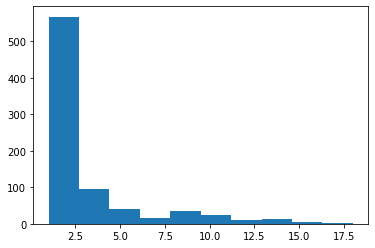

In [122]:
all_len = [len(c) for c in communities]
plt.hist(all_len)

## Try to cluster these: greedy_modularity_communities

Modularity degree based. This does not remove any edges or nodes, but is similar to a KNN vote

In [130]:
communities = nx.algorithms.community.greedy_modularity_communities(G)

<IPython.core.display.Javascript object>


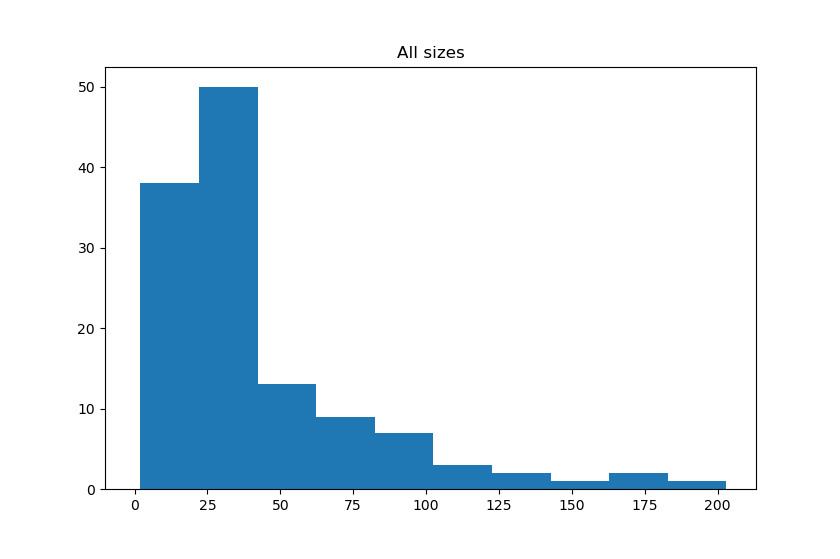

(array([38., 50., 13.,  9.,  7.,  3.,  2.,  1.,  2.,  1.]),
 array([  2. ,  22.1,  42.2,  62.3,  82.4, 102.5, 122.6, 142.7, 162.8,
        182.9, 203. ]),
 <BarContainer object of 10 artists>)

In [131]:
%matplotlib notebook
all_len = [len(c) for c in communities]
plt.hist(all_len)

## Try to cluster these: k-core

Naive degree based. This removes edges if they have few connections

In [102]:
DG_bp_kcore = nx.algorithms.core.k_core(DG_bp, k=4)


In [103]:
len(DG_bp_kcore.nodes())

1276

Largest connected component size:  1276
Sizes and number of components:
[1276, 1]


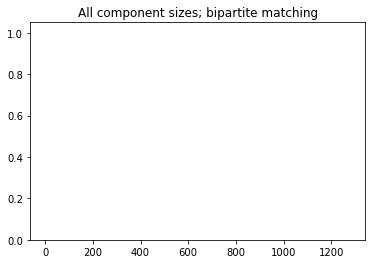

In [104]:
%matplotlib inline

G = DG_bp_kcore

big_G, all_sz, all_neurons = calc_connected_components(G, False)
plt.hist([z for z in all_sz if z > 1], bins=list(range(1,max(all_sz)+2)));
plt.title('All component sizes; bipartite matching')

[vals, counts] = np.unique(all_sz, return_counts=True)
print("Sizes and number of components:")
for v, c in zip(vals, counts):
      print([v, c])

## Try to cluster these: girvan_newman

Betweenness-centrality based. This removes edges if they are bottlenecks, which most of the incorrectly labeled neurons should be

In [133]:
# import itertools
k = 2

all_communities = []
comp = nx.algorithms.community.girvan_newman(DG_bp_small)
for communities in itertools.islice(comp, k):
    print(tuple(sorted(c) for c in communities))  

([67, 1103, 2134], [56, 1075, 2056], [114, 1112, 2133], [109, 1121, 1139, 2135, 2148], [137, 1148, 2166], [40, 1065, 2052], [16, 125, 127, 1012, 1118, 1169, 2001, 2004, 2118], [128, 1111, 2123], [90, 1108, 2081], [14, 1022, 2011], [105, 116, 145, 1135, 1155, 1159, 1164, 2107, 2126, 2159, 2173], [123, 1132, 2137], [79, 1087, 2069], [117, 1160, 2164], [18, 1034, 2032], [124, 1141, 2163], [99, 1149, 2172], [112, 136, 1154, 1171, 2108, 2138], [75, 1080, 2076], [12, 1014, 2025], [82, 1082, 2073], [126, 1144, 2155], [39, 1060, 2061], [3, 48, 80, 89, 142, 1058, 1098, 1105, 1158, 2046, 2082, 2088, 2121, 2153], [61, 1042, 2054], [122, 1162, 2157], [70, 93, 1072, 1078, 2063, 2071, 2093], [115, 1114, 2136], [46, 1047, 2051], [98, 1094, 2130], [28, 1052, 2044], [32, 1036, 2040], [106, 1097, 2085, 2116], [141, 1150, 2178], [68, 1091, 2079], [102, 1131, 2129], [107, 1130, 2122], [110, 1101, 2152], [119, 1123, 2117], [129, 1138, 2154], [58, 1049, 2042], [5, 1019, 1167, 2008, 2015], [60, 1051, 2043], 

In [ ]:
%matplotlib inline
thresh = 0.0

G = get_subgraph_with_strong_weights(DG_bp, thresh)
big_G, all_sz, all_neurons = calc_connected_components(G, False)
plt.hist([z for z in all_sz if z > 1], bins=list(range(1,max(all_sz)+2)));
plt.title('All component sizes; bipartite matching')

[vals, counts] = np.unique(all_sz, return_counts=True)
print("Sizes and number of components:")
for v, c in zip(vals, counts):
      print([v, c])

## Try to cluster these: node2vec

In [77]:
# Cluster based on graph embedding:
# https://stackoverflow.com/questions/62902871/how-can-i-cluster-a-graph-g-created-in-networkx

from node2vec import Node2Vec
# Generate walks
node2vec = Node2Vec(DG_bp, dimensions=2, walk_length=3, num_walks=10,workers=4)
# Learn embeddings 
model = node2vec.fit(window=10, min_count=1)
#model.wv.most_similar('1')
model.wv.save_word2vec_format("embedding.emb") #save the embedding in file embedding.emb

Computing transition probabilities:   0%|          | 0/2312 [00:00<?, ?it/s]

In [80]:
from sklearn.cluster import KMeans

# X = model.wv
X = np.loadtxt("embedding.emb", skiprows=1) # load the embedding of the nodes of the graph
#print(X)
# sort the embedding based on node index in the first column in X
X=X[X[:,0].argsort()]; 
Z=X[0:X.shape[0],1:X.shape[1]]; # remove the node index from X and save in Z

kmeans = KMeans(n_clusters=150, random_state=0).fit(Z) # apply kmeans on Z
labels=kmeans.labels_  # get the cluster labels of the nodes.
print(labels)

[136  22  19 ... 111  96  45]


In [81]:
np.unique(labels, return_counts=True)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149]),
 array([15, 26, 17, 15, 25, 16, 18, 22, 30, 13, 18,  9, 10, 19, 11, 17, 21,
        17, 27, 17, 18, 18, 24, 13, 15, 27,  8, 18,  7, 12, 16,  6, 10, 21,
